# Линейная регрессия

In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Постановка

In [96]:
raw = pd.read_csv("botswana.tsv", sep="\t", index_col=False) 
raw.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


In [97]:
raw.agefm.describe(include='0')

count    2079.000000
mean       20.686388
std         5.002383
min        10.000000
25%        17.000000
50%        20.000000
75%        23.000000
max        46.000000
Name: agefm, dtype: float64

In [101]:
raw.agefm

0        NaN
1       20.0
2       22.0
3        NaN
4       24.0
5       24.0
6       15.0
7       24.0
8       26.0
9       18.0
10      24.0
11      24.0
12      23.0
13      26.0
14      21.0
15       NaN
16       NaN
17       NaN
18      25.0
19      23.0
20      18.0
21      23.0
22      25.0
23      18.0
24       NaN
25      22.0
26      18.0
27       NaN
28       NaN
29       NaN
        ... 
4331     NaN
4332     NaN
4333     NaN
4334     NaN
4335     NaN
4336     NaN
4337     NaN
4338     NaN
4339     NaN
4340     NaN
4341     NaN
4342    19.0
4343     NaN
4344    30.0
4345     NaN
4346    16.0
4347     NaN
4348     NaN
4349     NaN
4350     NaN
4351     NaN
4352     NaN
4353    15.0
4354    18.0
4355    17.0
4356     NaN
4357     NaN
4358     NaN
4359    22.0
4360    21.0
Name: agefm, dtype: float64

Посмотрим на матрицу диаграмм рассеяния по количественным признакам:

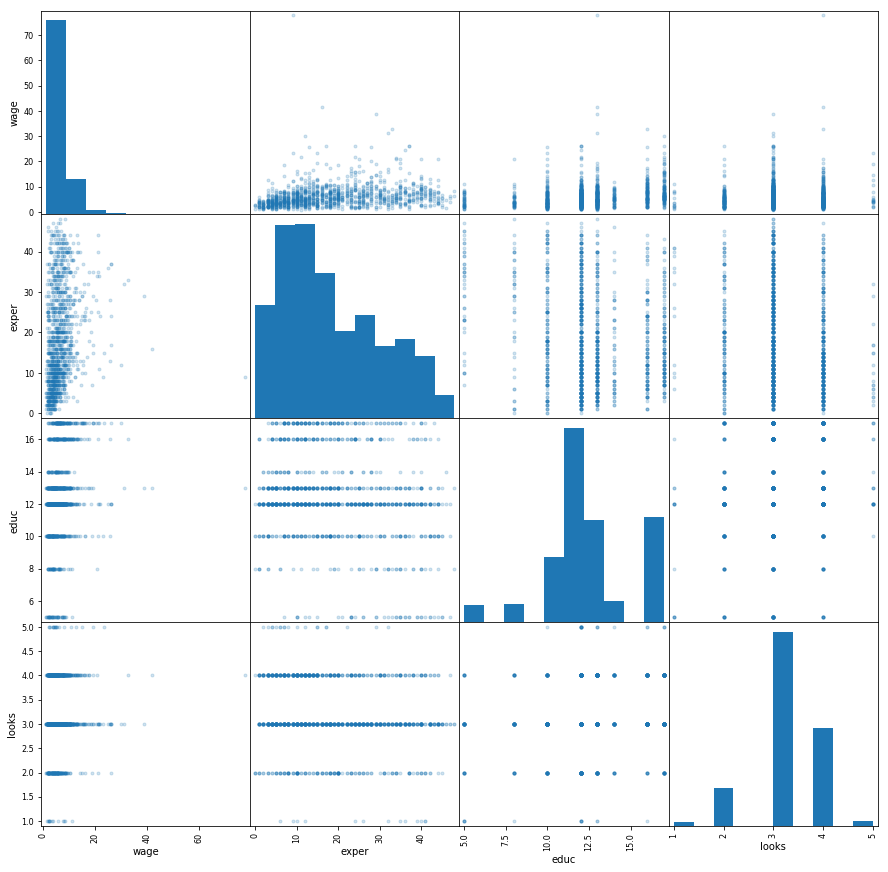

In [4]:
pd.tools.plotting.scatter_matrix(raw[['wage', 'exper', 'educ', 'looks']], alpha=0.2, 
                                 figsize=(15, 15), diagonal='hist')
pylab.show()

In [5]:
raw.corr()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
wage,1.000000,0.234632,0.094529,0.006756,-0.059052,-0.313419,0.184521,-0.053653,0.212333,0.055019
exper,0.234632,1.000000,0.089792,-0.131609,0.007566,-0.247209,0.255607,-0.057328,-0.186200,-0.155035
union,0.094529,0.089792,1.000000,-0.022398,0.031939,-0.100037,0.053629,-0.103633,-0.096022,-0.043495
goodhlth,0.006756,-0.131609,-0.022398,1.000000,-0.034073,-0.039684,-0.013315,0.049947,0.107129,0.058558
black,-0.059052,0.007566,0.031939,-0.034073,1.000000,0.113703,-0.133306,0.017261,-0.138157,0.012098
female,-0.313419,-0.247209,-0.100037,-0.039684,0.113703,1.000000,-0.319228,0.267961,0.009105,0.017129
married,0.184521,0.255607,0.053629,-0.013315,-0.133306,-0.319228,1.000000,-0.075082,-0.047674,-0.064636
service,-0.053653,-0.057328,-0.103633,0.049947,0.017261,0.267961,-0.075082,1.000000,0.301628,0.010213
educ,0.212333,-0.186200,-0.096022,0.107129,-0.138157,0.009105,-0.047674,0.301628,1.000000,0.153842
looks,0.055019,-0.155035,-0.043495,0.058558,0.012098,0.017129,-0.064636,0.010213,0.153842,1.000000


Оценим сбалансированность выборки по категориальным признакам:

In [6]:
print raw.union.value_counts()
print raw.goodhlth.value_counts()
print raw.black.value_counts()
print raw.female.value_counts()
print raw.married.value_counts()
print raw.service.value_counts()

0    917
1    343
Name: union, dtype: int64
1    1176
0      84
Name: goodhlth, dtype: int64
0    1167
1      93
Name: black, dtype: int64
0    824
1    436
Name: female, dtype: int64
1    871
0    389
Name: married, dtype: int64
0    915
1    345
Name: service, dtype: int64


У каждого признака все значения встречаются достаточно много раз, так что всё в порядке.

## Предобработка

In [7]:
data = raw

Посмотрим на распределение целевого признака — уровня заработной платы: 

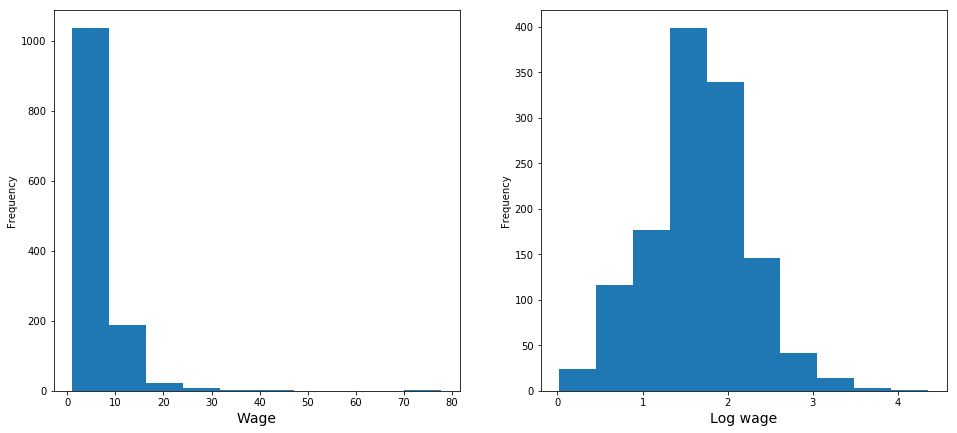

In [8]:
plt.figure(figsize(16,7))
plt.subplot(121)
data['wage'].plot.hist()
plt.xlabel('Wage', fontsize=14)

plt.subplot(122)
np.log(data['wage']).plot.hist()
plt.xlabel('Log wage', fontsize=14)
pylab.show()

Один человек в выборке получает 77.72\$ в час, остальные — меньше 45\$; удалим этого человека, чтобы регрессия на него не перенастроилась.

In [9]:
data = data[data['wage'] < 77]

Посмотрим на распределение оценок привлекательности: 

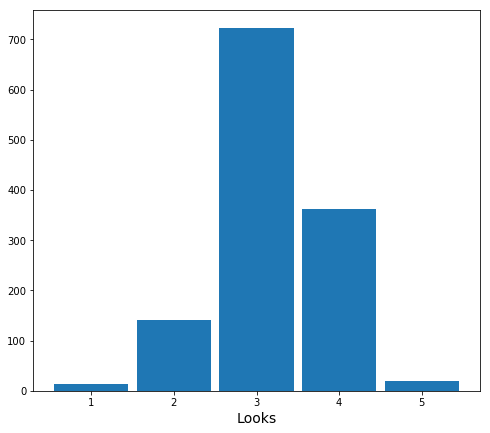

In [10]:
plt.figure(figsize(8,7))
data.groupby('looks')['looks'].agg(lambda x: len(x)).plot(kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.xlabel('Looks', fontsize=14)
pylab.show()

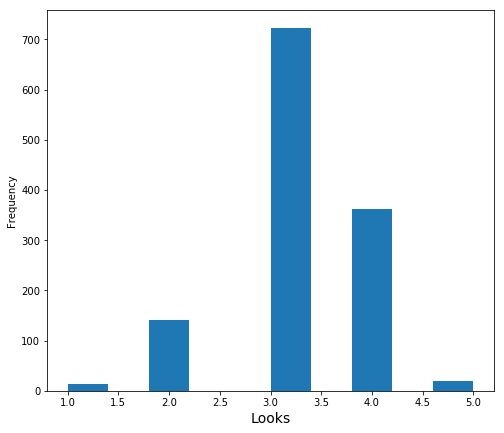

In [16]:
data['looks'].plot.hist()
plt.xlabel('Looks', fontsize=14)
pylab.show()

В группах looks=1 и looks=5 слишком мало наблюдений. Превратим признак looks в категориальный и закодируем с помощью фиктивных переменных:

In [25]:
data['belowavg'] = data['looks'].apply(lambda x : 1 if x < 3 else 0)
data['aboveavg'] = data['looks'].apply(lambda x : 1 if x > 3 else 0)
data.drop('looks', axis=1, inplace=True)

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/ipython2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.p

Данные теперь:

In [26]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


## Построение модели

### Простейшая модель

Построим линейную модель по всем признакам.

In [24]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married + service + educ + looks', 
             data=data)
fitted = m1.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     48.86
Date:                Fri, 30 Jun 2017   Prob (F-statistic):           7.60e-76
Time:                        16:40:44   Log-Likelihood:                -3404.3
No. Observations:                1259   AIC:                             6829.
Df Residuals:                    1249   BIC:                             6880.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.6592      0.855     -1.940      0.0

In [22]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married +'\
                    'service + educ + looks', 
             data=data)
fitted = m1.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     48.86
Date:                Fri, 30 Jun 2017   Prob (F-statistic):           7.60e-76
Time:                        16:39:30   Log-Likelihood:                -3404.3
No. Observations:                1259   AIC:                             6829.
Df Residuals:                    1249   BIC:                             6880.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.6592      0.855     -1.940      0.0

In [27]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married +'\
                    'service + educ + belowavg + aboveavg', 
             data=data)
fitted = m1.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.31
Date:                Fri, 30 Jun 2017   Prob (F-statistic):           1.42e-75
Time:                        16:41:22   Log-Likelihood:                -3402.9
No. Observations:                1259   AIC:                             6828.
Df Residuals:                    1248   BIC:                             6884.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.5898      0.743     -0.793      0.4

Посмотрим на распределение остатков:

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


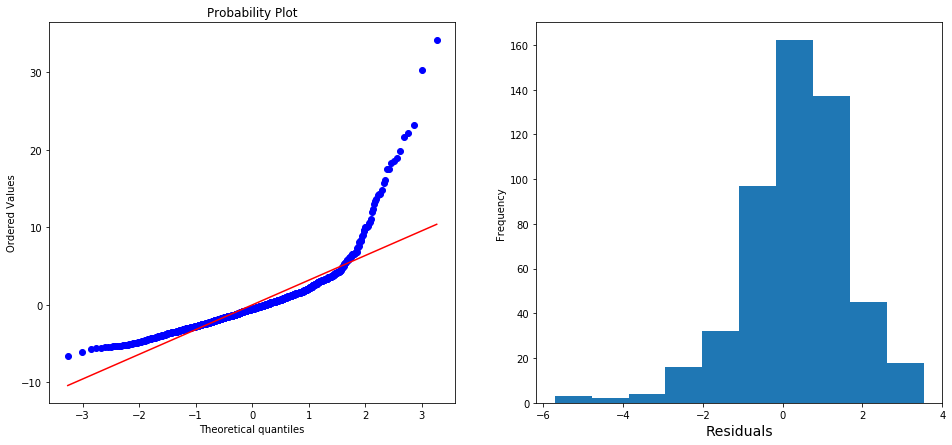

In [28]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Оно скошенное, как и исходный признак. В таких ситуациях часто помогает перейти от регрессии исходного признака к регрессии его логарифма.

### Логарифмируем отклик

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Fri, 30 Jun 2017   Prob (F-statistic):          1.18e-123
Time:                        16:43:57   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.0

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log


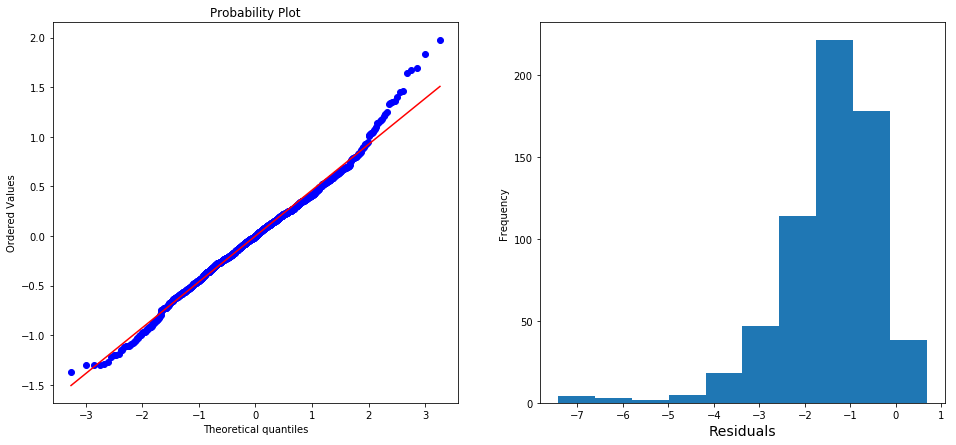

In [29]:
m2 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female + married +'\
                            'service + educ + belowavg + aboveavg', data=data)
fitted = m2.fit()
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Теперь стало лучше. Посмотрим теперь на зависимость остатков от непрерывных признаков:

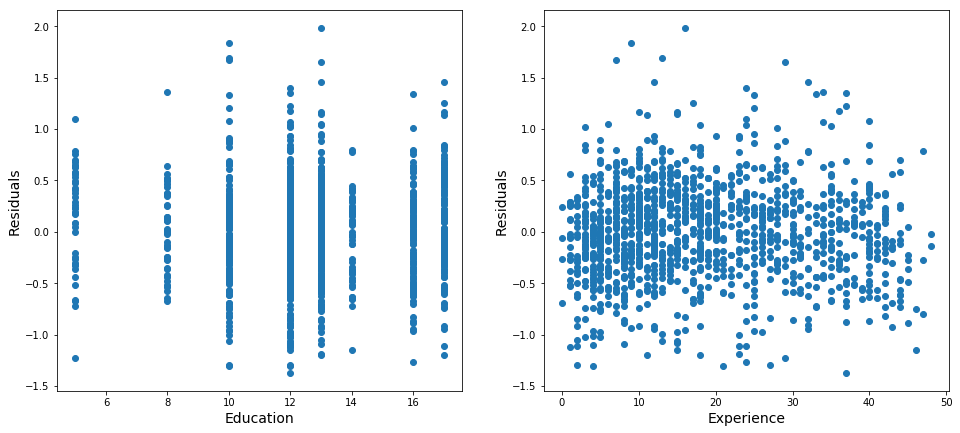

In [30]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

На втором графике видна квадратичная зависимость остатков от опыта работы. Попробуем добавить к признакам квадрат опыта работы, чтобы учесть этот эффект.

### Добавляем квадрат опыта работы

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     76.46
Date:                Fri, 30 Jun 2017   Prob (F-statistic):          3.19e-131
Time:                        16:46:34   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log


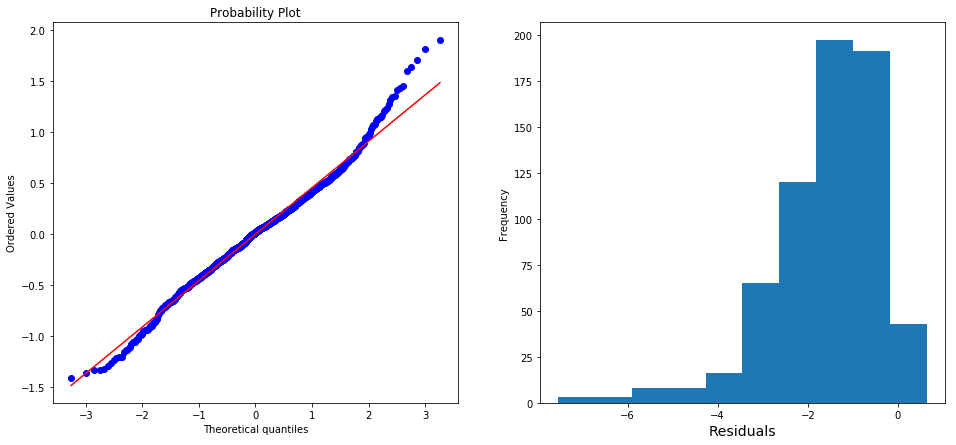

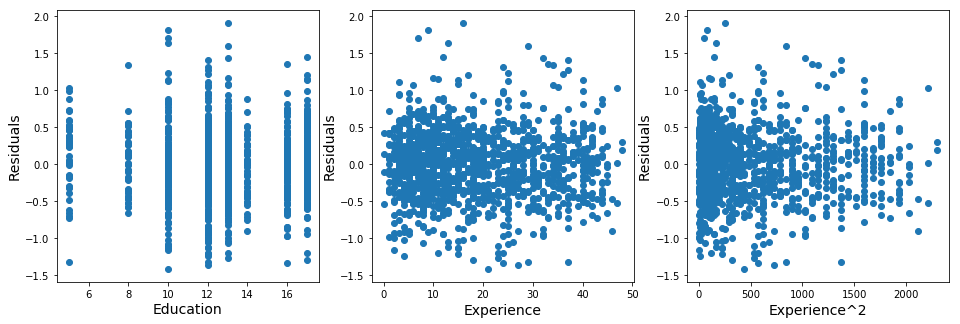

In [31]:
m3 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m3.fit()
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.figure(figsize(16,5))
plt.subplot(131)
scatter(data['educ'],fitted.resid)
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
scatter(data['exper'],fitted.resid)
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
scatter(data['exper']**2,fitted.resid)
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
pylab.show()

Используем критерий Бройша-Пагана для проверки гомоскедастичности ошибок:

In [32]:
print 'Breusch-Pagan test: p=%f' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1]

Breusch-Pagan test: p=0.000004


Ошибки гетероскедастичны, значит, значимость признаков может определяться неверно. Сделаем поправку Уайта:

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     87.29
Date:                Fri, 30 Jun 2017   Prob (F-statistic):          4.23e-146
Time:                        16:47:36   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log


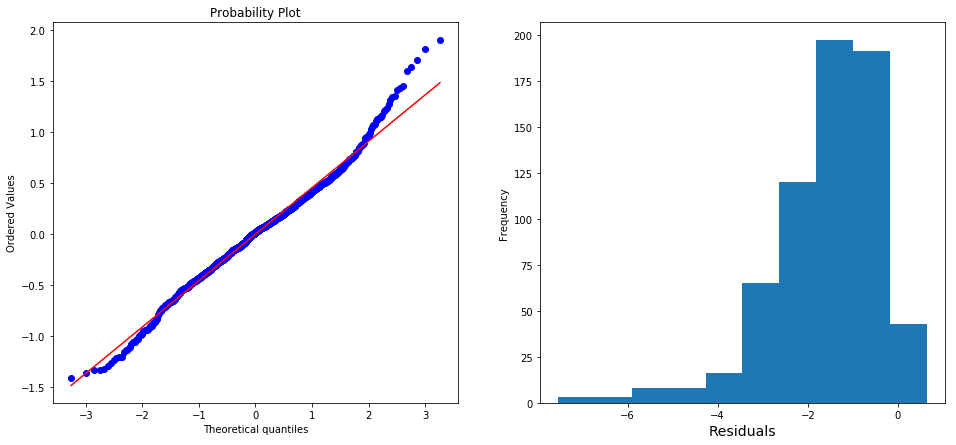

In [33]:
m4 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + belowavg + aboveavg', data=data)
fitted = m4.fit(cov_type='HC1')
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

### Удаляем незначимые признаки

В предыдущей модели незначимы: цвет кожи, здоровье, семейное положение. Удалим их. Индикатор привлекательности выше среднего тоже незначим, но удалять его не будем, потому что это одна из переменных, по которым на нужно в конце ответить на вопрос.

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     121.1
Date:                Fri, 30 Jun 2017   Prob (F-statistic):          6.49e-150
Time:                        16:50:56   Log-Likelihood:                -799.30
No. Observations:                1259   AIC:                             1617.
Df Residuals:                    1250   BIC:                             1663.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.3906      0

/anaconda/ipython2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log


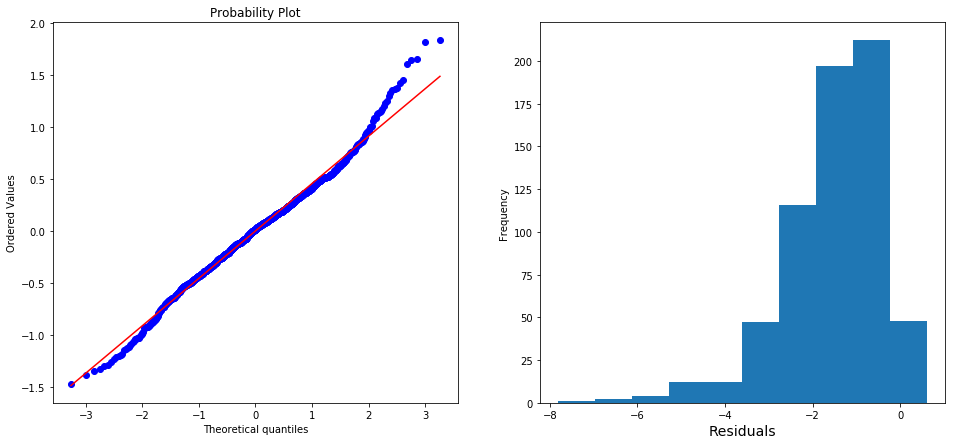

In [34]:
m5 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + female + service + educ +'\
                            'belowavg + aboveavg', data=data)
fitted = m5.fit(cov_type='HC1')
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Посмотрим, не стала ли модель от удаления трёх признаков значимо хуже, с помощью критерия Фишера:

In [35]:
print "F=%f, p=%f, k1=%f" % m4.fit().compare_f_test(m5.fit())

F=1.611478, p=0.184911, k1=3.000000


Не стала.

Проверим, нет ли наблюдений, которые слишком сильно влияют на регрессионное уравнение:

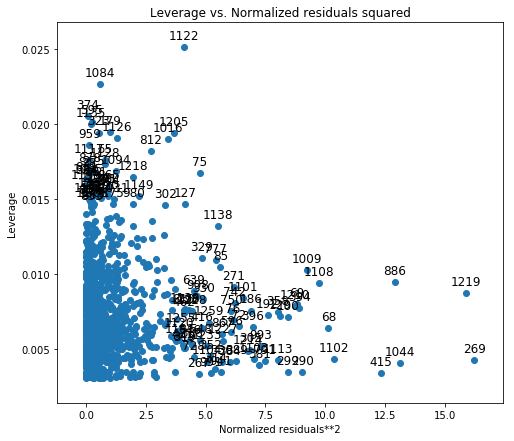

In [36]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

In [23]:
data.loc[[1122]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
1122,6.25,47,0,0,1,1,1,0,5,0,1


In [24]:
data.loc[[269]]

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
269,41.67,16,0,0,0,0,1,0,13,0,1


## Выводы

Итоговая модель объясняет 40% вариации логарифма отклика. 

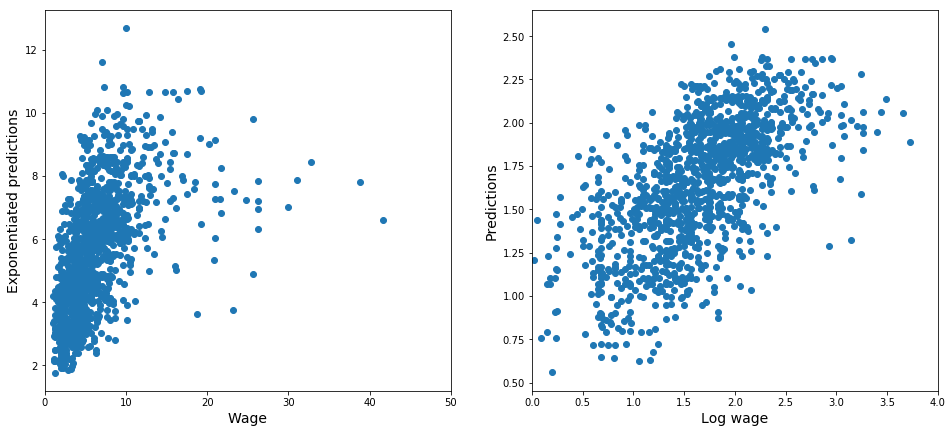

In [25]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(data['wage'],np.exp(fitted.fittedvalues))
plt.xlabel('Wage', fontsize=14)
plt.ylabel('Exponentiated predictions', fontsize=14)
plt.xlim([0,50])

plt.subplot(122)
scatter(np.log(data['wage']),fitted.fittedvalues)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xlim([0,4])
pylab.show()

При интересующих нас факторах привлекательности стоят коэффициенты -0.1307 (ниже среднего) и -0.0010 (выше среднего). 

Поскольку регрессия делалась на логарифм отклика, интерпретировать их можно как прирост в процентах. С учётом дополнительных факторов представители генеральной совокупности, из которой взята выборка, получают в среднем:

* на 13% меньше, если их привлекательность ниже среднего (p=0.001, 95% доверительный интервал — [5,21]%);
* столько же, если их привлекательность выше среднего (p=0.972, 95% доверительный интервал — [-6,6]%).